# Clustering Standard Errors
Julian Hsu
1-Apr-2024

The purpose of this script is to show how ignoring clustered errors will result in over-estimating precision.

**sound byte**

Is your experiment randomized at the user-group level, but your analysis uses user-level data? Then you are most likely incorrectly concluding your estimate is statistically significant. When your randomization and analysis level are not aligned,  classical approaches will give you a confidence interval and p-value that are too small. This is because classical approaches assume that errors are independent across users. 

This is the reason why you are not estimating the impact of your user-level experiment on individual user-transactions. You aggregate them up to the user. When you randomize at a group level, such as city or user-team level, then errors are correlated within that group. For example, if a treated city also happens to have more traffic, then all users in that city share the same impact from traffic. 

I show with simulations below that either (1) clustering standard errors with user-level data, or (2) aggregating your data to the user-group level, will correctly show you that randomizing at user-group level gives you less precise accurates than randomizing at the finer grain user level.


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  


## Data generating functions and Estimating Functions

In [3]:
def dgp(N=400, impact=0.5):
    err = np.random.normal(0,1,N)
    df_grp = pd.DataFrame(data={'id': np.arange( int(N/10))})
    df_grp['w'] = np.random.choice(2, len(df_grp))
    df_grp['gp_err'] = np.random.normal(0,0.5, len(df_grp))
    
    df = pd.DataFrame(data = {'id': np.random.choice(int(N/10), N)})
    df = df.merge(df_grp, how='inner', on='id')
    df['x'] = np.random.uniform(0,1,N)
    df['y'] = impact*df['w'] + df['gp_err'] + np.random.uniform(-2,1)* df['x']+ err
    return df


In [4]:
def different_estimates(df=None):
    classic=sm.OLS(exog=sm.add_constant(df[['w','x']])               
       , endog=df['y'] ).fit()
    A = classic.params['w'], classic.bse['w']
    
    
    cluster=sm.OLS(exog=sm.add_constant(df[['w','x']])               
       , endog=df['y'] ).fit(cov_type='cluster', cov_kwds={'groups':df['id']})
    B = cluster.params['w'], cluster.bse['w']
    
    
    df_g = df.groupby('id').agg( w=('w','max')
                            , x=('x','mean')
                           , y=('y','mean'))
    cluster=sm.OLS(exog=sm.add_constant(df_g[['w','x']])               
           , endog=df_g['y'] ).fit()
    C = cluster.params['w'], cluster.bse['w']
    
    return pd.DataFrame( data={'estimates':['coef','se']
                    , 'modelclassic':A
                    , 'modelcluster':B
                    , 'modelgroup':C})

## Simulations

In [5]:
sim_range=20

In [6]:
df_sim = pd.DataFrame()
for s in range(sim_range):
    data = dgp(N=200, impact=0.15)
    row = different_estimates(df=data)
    row['sim']=s
    df_sim = pd.concat([df_sim, row])

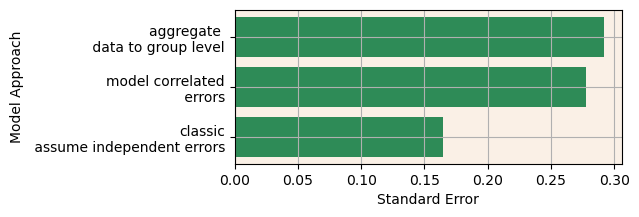

<Figure size 640x480 with 0 Axes>

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,2))

parts=ax.barh(
        np.arange(3)
        , df_sim.loc[df_sim['estimates']=='se'][['modelclassic'
                                                 , 'modelcluster'
                                                 , 'modelgroup']].mean()
    , color='seagreen')

ax.set_yticks(np.arange(0,3))
ax.set_yticklabels( ['classic\n assume independent errors','model correlated\n errors','aggregate \n data to group level']) 
ax.grid()
ax.set_ylabel('Model Approach')
ax.set_xlabel('Standard Error') 
ax.set_facecolor('linen')
plt.show()
plt.tight_layout()




In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,2))

parts=ax.violinplot(
        df_sim.loc[df_sim['estimates']=='se'][['modelclassic'
                                                 , 'modelcluster'
                                                 , 'modelgroup']], showmeans=True, showmedians=False, showextrema=False
                                                )

for pc in parts['bodies']:
    pc.set_facecolor('coral')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1,4))
ax.set_xticklabels( ['classic','clustered','aggregated\ndata']) 
ax.grid()
ax.set_xlabel('Model Approach')
ax.set_ylabel('Standard Error') 
ax.set_facecolor('linen')
plt.show()
plt.tight_layout()


